In [1]:
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import cv2
import tensorflow as tf 

from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import StratifiedShuffleSplit

random.seed(999)

Using TensorFlow backend.


In [2]:
IMAGES_PATH = "covers-jpg/"

In [3]:
image_files = list(os.listdir(IMAGES_PATH))
print("Number of image files: {}".format(len(image_files)))

Number of image files: 5810


The image size is: (170, 255)


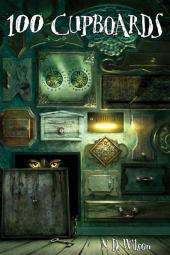

In [4]:
sample = Image.open('covers-jpg/10_100-cupboards-the-100-cupboards-book-1.jpg') 
print("The image size is: {}".format(sample.size))
sample

In [5]:
width = []
height = []
channels = []
for image in image_files: 
    img = cv2.imread(IMAGES_PATH+image)
    img = img.shape
    height.append(img[0])
    width.append(img[1])
    channels.append(img[2])

In [6]:
print("The average width of the covers is: {:.3f}".format(sum(width)/len(width)))
print("The average height of the covers is: {:.3f}".format(sum(height)/len(width)))
print("All {:d} images are in color".format(sum(map(lambda x : x == 3, channels))))

The average width of the covers is: 169.988
The average height of the covers is: 240.513
All 5810 images are in color


## Resize All Covers

In [7]:
!mkdir "covers-scaled"
new_path = "covers-scaled/"

mkdir: cannot create directory ‘covers-scaled’: File exists


In [8]:
for image in image_files:
    new_image = Image.open(IMAGES_PATH+image)
    new_image = new_image.resize((170, 240))
    new_image.save(new_path+image)

[Tutorial](https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification)

In [9]:
filenames = os.listdir('covers-scaled')

titles = []
ratings = []
for filename in filenames:
    ratings.append(filename.split('_')[0])
    titles.append(filename.split('_')[1])


In [10]:
df = pd.DataFrame({
    'title': titles,
    'rating': ratings
})

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5810 entries, 0 to 5809
Data columns (total 2 columns):
title     5810 non-null object
rating    5810 non-null object
dtypes: object(2)
memory usage: 90.9+ KB


In [12]:
FAST_RUN = False
IMAGE_WIDTH=170
IMAGE_HEIGHT=240
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

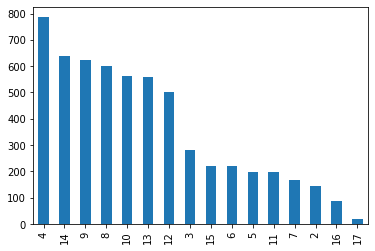

In [13]:
df['rating'].value_counts().plot.bar();

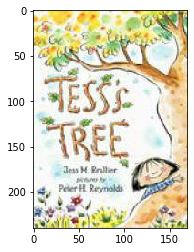

In [14]:
sample = random.choice(filenames)
image = load_img(new_path+sample)
plt.imshow(image)

## Build a Model

In [15]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1,activation='relu')) 

#Add loss function, metrics, optimizer

model.compile(optimizer="RMSprop", loss='mean_squared_error', metrics=["mae"]) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 168, 238, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 168, 238, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 84, 119, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 84, 119, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 82, 117, 64)       18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 82, 117, 64)       256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 41, 58, 64)       

### Callbacks

In [16]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_mae', 
                                            patience=10, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

### Split the Data

In [17]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=999, )

In [18]:
for train_df, validate_df in split.split(df, df['rating']):
    train_df = df.loc[train_df]
    validate_df = df.loc[validate_df]

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4648 entries, 0 to 4647
Data columns (total 2 columns):
title     4648 non-null object
rating    4648 non-null object
dtypes: object(2)
memory usage: 72.8+ KB


In [20]:
train_df['rating'].value_counts() / len(train_df)

4     0.135542
14    0.109725
9     0.107143
8     0.103055
10    0.096601
13    0.096170
12    0.086489
3     0.048623
15    0.037866
6     0.037651
11    0.034208
5     0.034208
7     0.029045
2     0.025172
16    0.015275
17    0.003227
Name: rating, dtype: float64

In [21]:
validate_df['rating'].value_counts() / len(validate_df)

4     0.135112
14    0.110155
9     0.107573
8     0.103270
13    0.096386
10    0.096386
12    0.086919
3     0.048193
15    0.037866
6     0.037866
5     0.034423
11    0.033563
7     0.029260
2     0.024957
16    0.015491
17    0.002582
Name: rating, dtype: float64

In [22]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=16

## Training Generator

### Fix dataframes to fit the generators

In [23]:
train_df.head()

,title,rating
0,the-curious-garden.jpg,4
1,dad-and-the-dinosaur.jpg,5
2,bitterblue.jpg,14
3,pretty-face.jpg,13
4,brontorina.jpg,4


In [24]:
train_df["title"] = train_df[['rating', "title"]].agg("_".join, axis=1)
validate_df["title"] = validate_df[['rating', "title"]].agg("_".join, axis=1)

In [25]:
train_df.head()

,title,rating
0,4_the-curious-garden.jpg,4
1,5_dad-and-the-dinosaur.jpg,5
2,14_bitterblue.jpg,14
3,13_pretty-face.jpg,13
4,4_brontorina.jpg,4


In [26]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [27]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    directory=new_path, 
    x_col='title',
    y_col='rating',
    target_size=IMAGE_SIZE,
    class_mode='raw',
    batch_size=batch_size
)

Found 4648 validated image filenames.


## Validation Generator

In [28]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    directory=new_path, 
    x_col='title',
    y_col='rating',
    target_size=IMAGE_SIZE,
    class_mode='raw',
    batch_size=batch_size
)

Found 1162 validated image filenames.


## See how our generator work

In [29]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    directory=new_path, 
    x_col='title',
    y_col='rating',
    target_size=IMAGE_SIZE,
    class_mode='raw'
)

Found 1 validated image filenames.


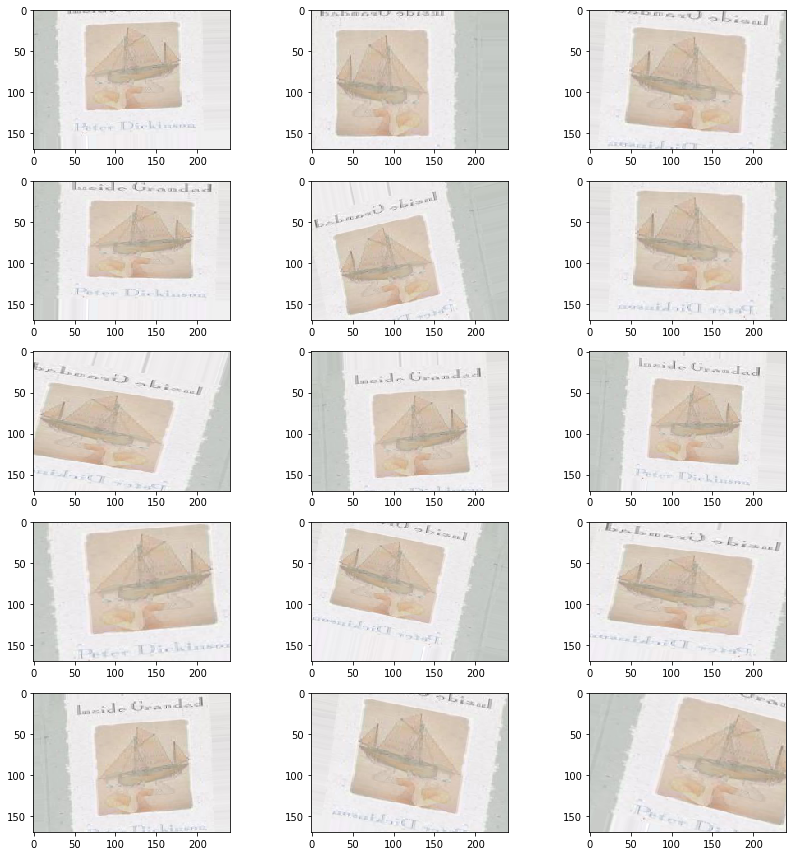

In [31]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.savefig("reports/generated_image.png")
plt.show()

# Fit the Model

In [32]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
290/290 [==============================] - 348s 1s/step - loss: 33.3450 - mae: 4.5583 - val_loss: 12.2868 - val_mae: 3.0880
Epoch 2/50
290/290 [==============================] - 329s 1s/step - loss: 23.6555 - mae: 3.8231 - val_loss: 19.1708 - val_mae: 2.8864
Epoch 3/50
290/290 [==============================] - 331s 1s/step - loss: 20.3072 - mae: 3.5230 - val_loss: 21.0591 - val_mae: 3.2244
Epoch 4/50
290/290 [==============================] - 328s 1s/step - loss: 17.3934 - mae: 3.3155 - val_loss: 7.5568 - val_mae: 3.0240
Epoch 5/50
290/290 [==============================] - 330s 1s/step - loss: 16.3821 - mae: 3.2232 - val_loss: 11.3564 - val_mae: 2.9459
Epoch 6/50
290/290 [==============================] - 330s 1s/step - loss: 14.9854 - mae: 3.1046 - val_loss: 23.8211 - val_mae: 3.6474
Epoch 7/50
290/290 [==============================] - 335s 1s/step - loss: 14.7825 - mae: 3.0782 - val_loss: 13.9947 - val_mae: 2.8686
Epoch 8/50
290/290 [==============================] - 34

In [33]:
model.save_weights("cover_model.h5")

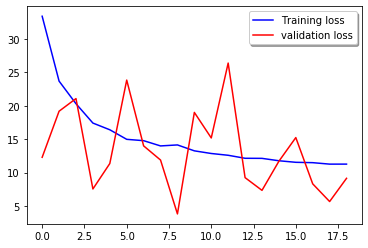

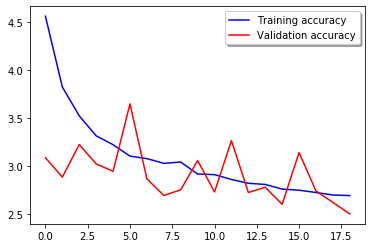

In [47]:
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.legend(loc='best', shadow=True)
plt.savefig('reports/cover_training.png')
plt.show()

plt.plot(history.history['mae'], color='b', label="Training accuracy")
plt.plot(history.history['val_mae'], color='r',label="Validation accuracy")
plt.legend(loc='best', shadow=True)
plt.savefig('reports/cover_mae.png')
plt.show()